In [1]:
import numpy as np
import random

import torch
import torch.nn.functional as F
import cl_gym as cl

import sys
import os

seed = 4
augment = 8

np.random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.cuda.manual_seed_all(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.enabled = False
torch.set_num_threads(4)


def make_params() -> dict:
    import os
    from pathlib import Path
    import uuid

    params = {
            # dataset
            'dataset': "MNIST",
            # 'dataset': "FashionMNIST",
            'random_class_idx': False,

            # benchmark
            'seed': seed,
            'num_tasks': 5,
            'epochs_per_task': 5,
            'per_task_examples': np.inf,
            # 'per_task_examples': 2000,
            'per_task_memory_examples': 64,
            'batch_size_train': 64,
            'batch_size_memory': 64,
            'batch_size_validation': 256,
            'tau': 10.,
            # 'tau': 0.0,

            # algorithm
            'optimizer': 'sgd',
            'learning_rate': 0.001,
            'momentum': 0.9,
            'learning_rate_decay': 1.0,
            'criterion': torch.nn.CrossEntropyLoss(),
            'device': torch.device('cuda:2' if torch.cuda.is_available() else 'cpu'),
             
            # sample selection
            'alpha':0.001,
            'lambda': 1.,
            'lambda_old': 0.0,
              }

#     trial_id = str(uuid.uuid4())
    trial_id = f"demo/dataset={params['dataset']}/seed={params['seed']}_epoch={params['epochs_per_task']}_lr={params['learning_rate']}_alpha={params['alpha']}_tau={params['tau']}"
    params['trial_id'] = trial_id
    params['output_dir'] = os.path.join("./outputs/{}".format(trial_id))
    print(f"output_dir={params['output_dir']}")
    Path(params['output_dir']).mkdir(parents=True, exist_ok=True)

    return params

params = make_params()

output_dir=./outputs/demo/dataset=MNIST/seed=4_epoch=5_lr=0.001_alpha=0.001_tau=10.0


In [2]:
from datasets import MNIST
from datasets import FashionMNIST
from datasets import CIFAR10, CIFAR100

if params['dataset'] == 'MNIST':
    benchmark = MNIST(num_tasks=params['num_tasks'],
                    per_task_memory_examples=params['per_task_memory_examples'],
                    per_task_examples = params['per_task_examples'],
                    random_class_idx = params['random_class_idx'],
                    augment=augment)
    input_dim = (28, 28)
elif params['dataset'] == 'FashionMNIST':
    benchmark = FashionMNIST(num_tasks=params['num_tasks'],
                            per_task_memory_examples=params['per_task_memory_examples'],
                            per_task_examples = params['per_task_examples'],
                            random_class_idx = params['random_class_idx'])
    input_dim = (28, 28)
elif params['dataset'] == 'CIFAR10':
    benchmark = CIFAR10(num_tasks=params['num_tasks'],
                        per_task_memory_examples=params['per_task_memory_examples'],
                        per_task_examples = params['per_task_examples'],
                        random_class_idx = params['random_class_idx'])
    input_dim = (3, 32, 32)
elif params['dataset'] == 'CIFAR100':        
    benchmark = CIFAR100(num_tasks=params['num_tasks'],
                        per_task_memory_examples=params['per_task_memory_examples'],
                        per_task_examples = params['per_task_examples'],
                        random_class_idx = params['random_class_idx'])
    input_dim = (3, 32, 32)
else:
    raise NotImplementedError
class_idx = benchmark.class_idx
num_classes = len(class_idx)



[0 1 2 3 4 5 6 7 8 9]


In [3]:
from algorithms.imbalance import Heuristic2
from metrics import MetricCollector2
from backbones import MLP2Layers2

backbone = MLP2Layers2(
    input_dim=input_dim, 
    hidden_dim_1=256, 
    hidden_dim_2=256, 
    output_dim=num_classes,
    class_idx=class_idx,
    config=params
    ).to(params['device'])
algorithm = Heuristic2(backbone, benchmark, params, requires_memory=True)
metric_manager_callback = MetricCollector2(num_tasks=params['num_tasks'],
                                                        eval_interval='epoch',
                                                        epochs_per_task=params['epochs_per_task'])

In [4]:
# from trainers import ContinualTrainer
# from trainers.fair_trainer import FairContinualTrainer2 as ContinualTrainer
from trainers.imbalance_trainer import ImbalanceContinualTrainer1 as ContinualTrainer

trainer = ContinualTrainer(algorithm, params, callbacks=[metric_manager_callback])


---------------------------- Task 1 -----------------------
[1] Eval metrics for task 1 >> {'accuracy': 0.9989795918367347, 'loss': 1.0446807819288709e-05, 'std': 0.0010204081632653184, 'EER': -1}
[2] Eval metrics for task 1 >> {'accuracy': 0.9989795918367347, 'loss': 8.654128471125208e-06, 'std': 0.0010204081632653184, 'EER': -1}
[3] Eval metrics for task 1 >> {'accuracy': 0.9989795918367347, 'loss': 7.73816615514827e-06, 'std': 0.0010204081632653184, 'EER': -1}
[4] Eval metrics for task 1 >> {'accuracy': 0.9989795918367347, 'loss': 6.585052876373264e-06, 'std': 0.0010204081632653184, 'EER': -1}
[5] Eval metrics for task 1 >> {'accuracy': 0.9989795918367347, 'loss': 6.97856272342912e-06, 'std': 0.0010204081632653184, 'EER': -1}
training_task_end
---------------------------- Task 2 -----------------------
losses=tensor([[4.2370e-03, 5.8813e-05, 1.1612e+01, 1.1698e+01]])
Elapsed time(grad):137.646
### Cplex absolute_and_nonabsolute_minsum LP solver ###
Elapsed time(optim):557.218
Fairne

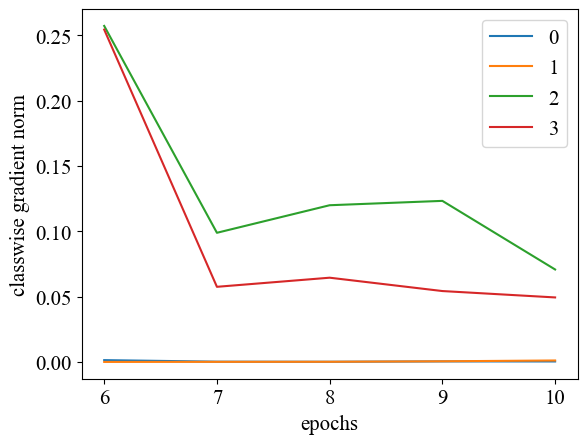

---------------------------- Task 3 -----------------------
losses=tensor([[8.9773e-04, 1.5867e-03, 1.1395e-01, 2.3757e-01, 1.2892e+01, 1.3848e+01]])
Elapsed time(grad):106.355
### Cplex absolute_and_nonabsolute_minsum LP solver ###
Elapsed time(optim):563.112
Fairness:[ 0.00000000e+00  1.97986263e-01 -1.28297767e-01 -1.11022302e-16
 -3.48443283e-02 -3.48444537e-02]
len(updated_seq_indices)=27072
Elapsed time(etc):0.748
[11] Eval metrics for task 1 >> {'accuracy': 0.9509574755012137, 'loss': 0.0009685786586281256, 'std': 0.008226197968174032, 'EER': -1}
[11] Eval metrics for task 2 >> {'accuracy': 0.8730591373090797, 'loss': 0.0019244710448673259, 'std': 0.009692800675416391, 'EER': -1}
[11] Eval metrics for task 3 >> {'accuracy': 0.9347812188907054, 'loss': 0.0008047174666327372, 'std': 0.04688884220909101, 'EER': -1}
losses=tensor([[0.0020, 0.0023, 0.0020, 0.0028, 0.0823, 0.2884]])
Elapsed time(grad):102.165
### Cplex absolute_and_nonabsolute_minsum LP solver ###
Elapsed time(optim):

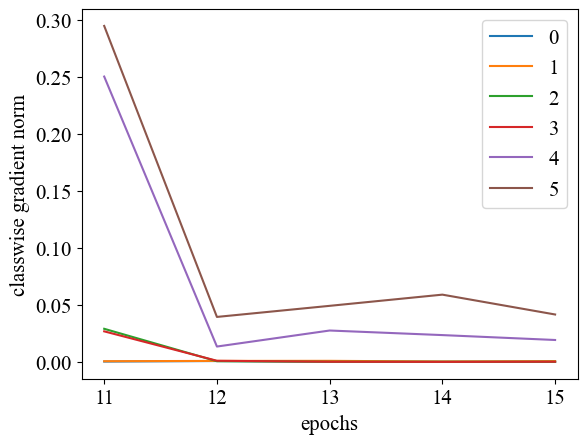

---------------------------- Task 4 -----------------------
losses=tensor([[2.1372e-04, 1.3887e-03, 5.3101e-04, 5.8112e-04, 1.3937e-01, 3.6460e-01,
         1.6220e+01, 1.3343e+01]])
Elapsed time(grad):117.043
### Cplex absolute_and_nonabsolute_minsum LP solver ###
Elapsed time(optim):970.805
Fairness:[ 0.          0.2801909   0.          0.14798704 -0.32496665 -0.12545524
  0.01112191  0.01112197]
len(updated_seq_indices)=33152
Elapsed time(etc):0.495
[16] Eval metrics for task 1 >> {'accuracy': 0.8860491773802032, 'loss': 0.0022211327338613235, 'std': 0.025845095747550118, 'EER': -1}
[16] Eval metrics for task 2 >> {'accuracy': 0.839964694143833, 'loss': 0.003037650280437787, 'std': 0.036004298104229004, 'EER': -1}
[16] Eval metrics for task 3 >> {'accuracy': 0.8810905720000365, 'loss': 0.002153721712569417, 'std': 0.05373631191035044, 'EER': -1}
[16] Eval metrics for task 4 >> {'accuracy': 0.9519680673907216, 'loss': 0.0007400074026435763, 'std': 0.022979740542472538, 'EER': -1}
los

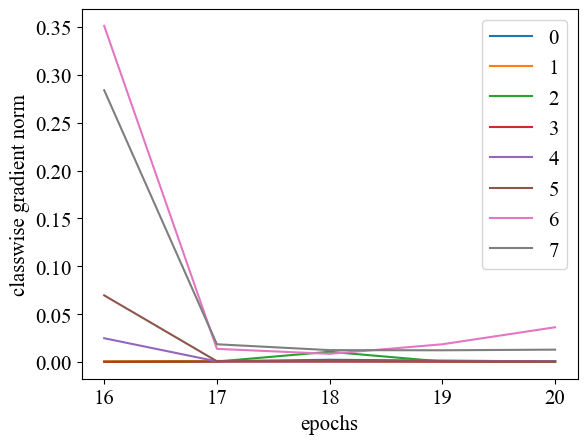

---------------------------- Task 5 -----------------------
losses=tensor([[9.1785e-04, 2.9515e-03, 4.6550e-04, 1.1865e-03, 1.9932e-03, 1.3636e-03,
         1.4142e-01, 1.2978e-01, 1.3118e+01, 1.4401e+01]])
Elapsed time(grad):106.611
### Cplex absolute_and_nonabsolute_minsum LP solver ###
Elapsed time(optim):1114.496
Fairness:[ 9.76392594e-02  1.76397060e-01  0.00000000e+00  0.00000000e+00
 -2.25569871e-01  0.00000000e+00  0.00000000e+00  5.55111512e-17
 -2.42335990e-02 -2.42334771e-02]
len(updated_seq_indices)=33280
Elapsed time(etc):0.39
[21] Eval metrics for task 1 >> {'accuracy': 0.8834801762114537, 'loss': 0.0025891899358014407, 'std': 0.016519823788546273, 'EER': -1}
[21] Eval metrics for task 2 >> {'accuracy': 0.7233354440095172, 'loss': 0.005714359409545241, 'std': 0.04313742420753702, 'EER': -1}
[21] Eval metrics for task 3 >> {'accuracy': 0.7537536646178294, 'loss': 0.004625149126877271, 'std': 0.03850702784652904, 'EER': -1}
[21] Eval metrics for task 4 >> {'accuracy': 0.900

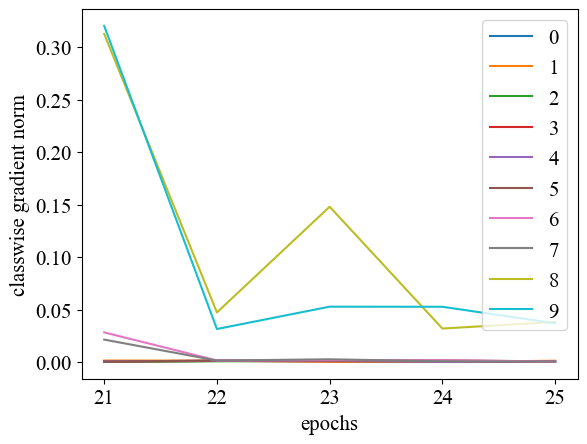

final avg-acc 0.8508381457339607
final avg-forget 0.10222334315739717


In [5]:
trainer.run()
print("final avg-acc", metric_manager_callback.meters['accuracy'].compute_final())
print("final avg-forget", metric_manager_callback.meters['forgetting'].compute_final())

In [6]:
g = algorithm.grad_calculation_time
o = algorithm.optim_time
e = algorithm.etc_prepare_time
t = algorithm.overall_training_time


for task in range(2, 6):
    print(np.round(np.sum(list(g[task].values())), 4), end="\t")
print()
for task in range(2, 6):
    print(np.round(np.sum(list(o[task].values())), 4), end="\t")
print()
for task in range(2, 6):
    print(np.round(np.sum(list(e[task].values())), 4), end="\t")
print()
for task in range(2, 6):
    print(np.round(np.sum(list(t[task])), 4), end="\t")


631.3763	510.0459	583.4044	546.0484	
2722.6263	2970.4306	4755.132	5165.4393	
2.8029	2.7789	2.3776	2.1687	
3370.1664	3494.0314	5348.9934	5725.2964	

In [7]:
for task in range(2, 6):
    print(np.round(np.mean(list(o[task].values())), 4), end="\t")


544.5253	594.0861	951.0264	1033.0879	

In [8]:
num_class_per_task = 2
num_epochs = params['epochs_per_task']

t = algorithm.true_loss
e = algorithm.expected_loss

groupwise_true_loss = dict()
groupwise_expected_loss = dict()

for i in range(num_classes):
    groupwise_true_loss[i] = dict()
    groupwise_expected_loss[i] = dict()

for task in range(2, params['num_tasks']+1):
    for epoch in range(1, num_epochs+1):
        true_loss = np.round(t[task][epoch].cpu().detach().numpy().astype("float64"), 4).reshape(-1)
        excepted_loss = np.round(e[task][epoch].cpu().detach().numpy().astype("float64"), 4).reshape(-1)
        for i, (tl, el) in enumerate(zip(true_loss, excepted_loss)):
            groupwise_true_loss[i][(task-1)*num_epochs+epoch] = tl
            groupwise_expected_loss[i][(task-1)*num_epochs+epoch] = el
            
    #     num_class_per_task
    #     print(np.round(t[task][epoch].cpu().detach().numpy().astype("float64"), 4).reshape(-1), end="\t")
    #     print(np.round(e[task][epoch].cpu().detach().numpy().astype("float64"), 4).reshape(-1), end="\t")
    #     print()
    # print()


KeyError: 1

In [ ]:
for c in range(num_classes):
    for t in range(2, params['num_tasks']+1):
        for e in range(1, num_epochs+1):
            ce = (t-1)*num_epochs+e # current epoch
            if c//num_class_per_task >= t:
                print(f"\t", end='')
                continue
            print(groupwise_true_loss[c][ce], end='\t')
    print()


0.1511	0.1507	0.0277	0.0041	0.0013	0.0061	0.0389	0.0643	0.0236	0.0093	0.0053	0.0379	0.0158	0.0126	0.0105	0.0045	0.0419	0.0325	0.019	0.0149	
0.0421	0.0262	0.0175	0.0091	0.0065	0.0013	0.0124	0.0125	0.0088	0.0053	0.0027	0.0503	0.0196	0.0172	0.0103	0.0034	0.0609	0.0305	0.0224	0.0226	
3.0007	0.8983	0.3663	0.2498	0.2789	0.2365	0.1297	0.0888	0.0266	0.0077	0.1204	0.1219	0.0363	0.018	0.012	0.0087	0.0634	0.0495	0.0192	0.0155	
3.4409	0.93	0.4023	0.3049	0.2669	0.4693	0.2546	0.2673	0.1146	0.0551	0.0048	0.0279	0.0174	0.0106	0.0082	0.0046	0.0559	0.0436	0.0188	0.0241	
					4.3974	1.5067	0.4799	0.2637	0.2324	0.4293	0.3421	0.0809	0.0254	0.0149	0.1179	0.2694	0.1589	0.0804	0.0639	
					5.0382	1.3121	0.4938	0.3652	0.3241	0.5419	0.1434	0.0386	0.0197	0.0187	0.0306	0.1305	0.0869	0.0334	0.0272	
										5.0632	0.7144	0.3471	0.2912	0.2662	0.3388	0.1015	0.0479	0.0263	0.0242	
										4.4336	0.968	0.3449	0.3953	0.382	0.4046	0.18	0.1187	0.0908	0.0449	
															4.4351	0.6763	0.2874	0.2702	0.2337	
										

In [ ]:
for c in range(num_classes):
    for t in range(2, params['num_tasks']+1):
        for e in range(1, num_epochs+1):
            ce = (t-1)*num_epochs+e # current epoch
            if c//num_class_per_task >= t:
                print(f"\t", end='')
                continue
            print(groupwise_expected_loss[c][ce], end='\t')
    print()


0.2978	0.8087	0.3334	0.1811	0.1643	0.1165	0.497	0.4746	0.3076	0.2268	-0.0671	0.0618	0.1279	0.0947	0.1069	-0.0965	0.1203	0.2849	0.1982	0.193	
0.0939	0.5349	0.2819	0.1811	0.1643	-0.2255	-0.0392	0.0419	0.0541	0.0689	-0.1598	0.0845	0.154	0.145	0.1338	-0.1463	0.0131	0.2147	0.2011	0.1966	
5.8602	0.7727	0.3076	0.1811	0.1643	0.1645	0.4686	0.4561	0.264	0.16	0.2822	0.4908	0.3618	0.294	0.2052	-0.0265	0.217	0.3109	0.2737	0.2248	
6.6361	0.746	0.3076	0.1811	0.1643	0.4709	0.669	0.6385	0.4586	0.3593	-0.1151	0.0938	0.1844	0.145	0.1338	-0.097	0.2056	0.293	0.2387	0.2147	
					7.9648	1.1156	0.2555	-0.0	-0.0	0.4927	0.9484	0.4625	0.3362	0.357	0.2539	0.6061	0.5674	0.4841	0.476	
					10.3207	1.3935	0.3733	0.2168	0.1447	0.3286	0.3486	0.1844	0.145	0.1338	0.051	0.5001	0.4361	0.3436	0.2938	
										11.2336	0.4637	0.0	-0.0	0.0	0.2568	0.2803	0.2628	0.2033	0.1769	
										8.2483	0.7318	-0.0	-0.0	-0.0	0.3483	0.7703	0.5599	0.5473	0.3816	
															10.1792	0.7287	-0.0	0.0	0.0	
															9.9933	0.4914	0.0	

In [ ]:
print(f"accuracy:{np.mean(metric_manager_callback.meters['accuracy'].compute_overall())}")
print(f"EER:{np.mean(metric_manager_callback.meters['EER'].compute_overall())}")
print(f"std:{np.mean(metric_manager_callback.meters['std'].compute_overall())}")


accuracy:0.9203303510487781
EER:0.029785069785202144
std:0.03966120659510891
